# 負の二項分布でのスコア法

* 黒木玄
* 2024-09-21

このノートでは $k > 0$, $0 < p \le 1$ について負の二項分布を次の確率質量函数によって定義する:

$$
P(n|k,p) = \binom{n-1}{k-1} p^k (1-p)^{n-k} \quad(n=k, k+1, k+2, \ldots)
$$

この分布はJulia言語のDistributions.jlでは `NegativeBinomial(k, p) + k` で得られる.

スコア法でのχ²検定統計量は尤度函数だけで決まり, しかも定数倍の違いを除いて等しい尤度函数達はスコア法での同一のχ²検定統計量を与える. ゆえに負の二項分布モデルのスコア法でのχ²検定統計量は二項分布モデルでにスコア法のχ²統計量に式の形が一致し, 次の形になる:

$$
\chi^2 = \frac{(k - np)^2}{np(1-p)} = \frac{(\hat{p} - p)^2}{p(1-p)/n} \quad\left(\hat{p}=\frac{k}{n}\right)
$$

二項分布モデルでのスコア検定は二項分布の正規分布近似による検定に等しい.

ゆえに, 「ちょうど $k$ 回当たりが出るまでルーレットを回した回数は $n$ 回だった」というデータの数値に関する検定仮説「当たりが出る確率は $p$ である」の負の二項分布モデルのスコア法でのP値は, 「$n$ 回ルーレットを回したら当たりがちょうど $k$ 回出た」というデータの数値に関する検定仮説「当たりが出る確率は $p$ である」の二項分布モデルでの二項分布の正規分布によるP値にぴったり等しくなる.

二項分布と負の二項分布での確率を正確に計算する方法によるP値を比較して「違う！」と騒ぎ立てることを行なっている人達が再生産され続けているようだが, そういう人達は同一の統計モデルであっても複数の異なるP値の構成法があることを無視している. その無視の原因はおそらくP値についての無知だと思われるが, もしも無知でないのに自分にとって都合の良いP値の構成法(確率を正確に計算する方法によるP値)を選んで「違う！」と騒ぎ立てているならば非常に悪質な行為だと言わざるを得ない.  悪質な行為に騙されないように注意した方が良い.

二項分布モデルの場合に近似を使う方法の方がある基準では優れていると考えられることについては次の論文を参照せよ:

* Alan Agresti and Brent A. Coull, Approximate is better than “exact” for interval estimation of binomial proportions, 1998. https://scholar.google.co.jp/scholar?cluster=5129299358902170657

以下は負の二項分布のスコア法関係のグラフを色々書いてみる

In [1]:
using Distributions
using StatsPlots
default(fmt=:png)

NegBin(k, p) = NegativeBinomial(k, p) + k

function pvalue_score(k, n, p)
    p̂ = k/n
    χ² = (p̂ - p)^2 / (p*(1-p)/n)
    ccdf(Chisq(1), χ²)
end

function pvalue_score(negbin, n)
    k, p = params(negbin.ρ)
    pvalue_score(k, n, p)
end

function pvalue_central(negbin, n)
    min(1, 2cdf(negbin, n), 2ccdf(negbin, n-1))
end

function pvalue_bayes_eti(k, n, p; prior=Beta(1/3, 1/3))
    κ, λ = params(prior)
    beta = Beta(κ+k, λ+n-k)
    min(1, 2cdf(beta, p), 2ccdf(beta, p))
end

function pvalue_bayes_eti(negbin, n; prior=Beta(1/3, 1/3))
    k, p = params(negbin.ρ)
    pvalue_bayes_eti(k, n, p; prior)
end

function pvalue_central_bin(k, n, p)
    bin = Binomial(n, p)
    min(1, 2cdf(bin, k), 2ccdf(bin, k-1))
end

function pvalue_central_bin(negbin, n)
    k, p = params(negbin.ρ)
    pvalue_central_bin(k, n, p)
end

function expectval(f, negbin)
    k, p = params(negbin.ρ)
    μ, σ = mean(negbin), std(negbin)
    nmin, nmax = max(k, round(Int, μ-6σ)), round(Int, μ+6σ)
    sum(f(n) * pdf(negbin, n) for n in nmin:nmax)
end

function probsig(pvalfunc, negbin0, negbin1=negbin0; α=0.05)
    expectval(n -> pvalfunc(negbin0, n) < α, negbin1)
end

function plot_alphaerror(; k=7, p=0.5, prior=Beta(1/3, 1/3), αmax=1.0)
    plot(α -> probsig(pvalue_score, NegBin(k, p); α), 0, αmax; label="score")
    plot!(α -> probsig(pvalue_central, NegBin(k, p); α); label="NegBin central", ls=:dash)
    plot!(α -> probsig((nb, n) -> pvalue_bayes_eti(nb, n; prior), NegBin(k, p); α); label="Bayes ETI", ls=:dashdot)
    plot!(α -> probsig(pvalue_central_bin, NegBin(k, p); α); label="Bin central", ls=:dot)
    plot!(identity; label="", c=:black, lw=0.5)
    plot!(xguide="α", yguide="probability of P-value < α")
    title!("k = $k, p = $p")
    plot!(size=(400, 400))
end

function plot_coverageprob(; k=7, α=0.05, prior=Beta(1/3, 1/3), 
        pmin=0.001, pmax=0.999, f=Bool[1,1,0,0], 
        lw=1, ylim=(0.895, 1.005), kwargs...
    )
    ps = range(pmin, pmax, 1001)
    plot()
    f[1] && plot!(ps, p -> 1 - probsig(pvalue_score, NegBin(k, p); α); label="score", c=1, lw)
    f[2] && plot!(ps, p -> 1 - probsig(pvalue_central, NegBin(k, p); α); label="NegBin central", c=2, lw)
    f[3] && plot!(ps, p -> 1 - probsig((nb, n)->pvalue_bayes_eti(nb, n; prior), NegBin(k, p); α); label="Bayes ETI", c=3, lw)
    f[4] && plot!(ps, p -> 1 - probsig(pvalue_central_bin, NegBin(k, p); α); label="Bin central", c=4, lw)
    hline!([1-α]; label="", c=:red)
    plot!(xguide="p", yguide="probability of P-value ≥ α")
    title!("k = $k,  1 - α = $(100(1-α))%")
    plot!(; ylim, kwargs...)
end

function plot_pvalue(; k=7, n=24, pmin=0.0, pmax=1.0, f=Bool[1,1,1,1], prior=Beta(1/3, 1/3))
    plot()
    f[1] && plot!(p -> pvalue_score(k, n, p), pmin, pmax; label="score", c=1)
    f[2] && plot!(p -> pvalue_central(NegBin(k, p), n), pmin, pmax; label="NegBin central", ls=:dash, c=2)
    f[3] && plot!(p -> pvalue_bayes_eti(k, n, p; prior), pmin, pmax; label="Bayes ETI", ls=:dashdot, c=3)
    f[4] && plot!(p -> pvalue_central_bin(k, n, p), pmin, pmax; label="Bin central", ls=:dot, c=4)
    plot!(xtick=0:0.1:1, ytick=0:0.05:1)
    plot!(xguide="p", yguide="P-value")
    title!("k = $k,  n = $n")
end

plot_pvalue (generic function with 1 method)

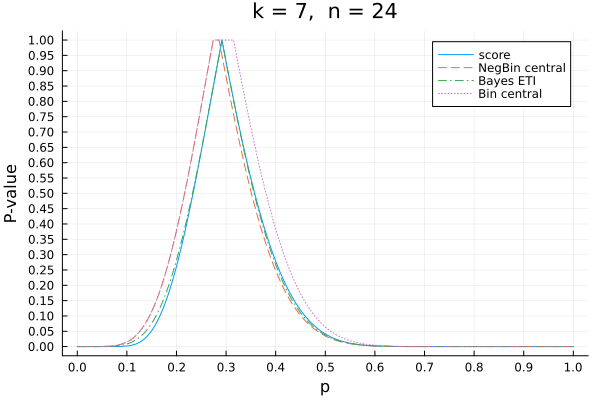

In [2]:
plot_pvalue(; k=7, n=24)

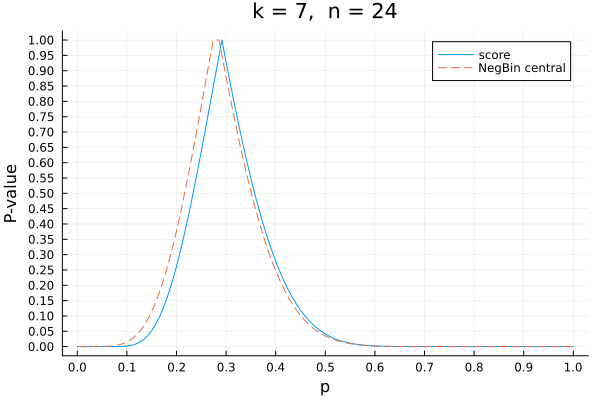

In [3]:
plot_pvalue(; k=7, n=24, f=Bool[1,1,0,0])

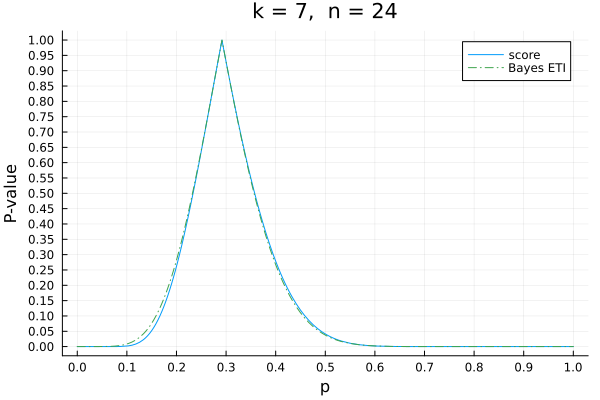

In [4]:
plot_pvalue(; k=7, n=24, f=Bool[1,0,1,0])

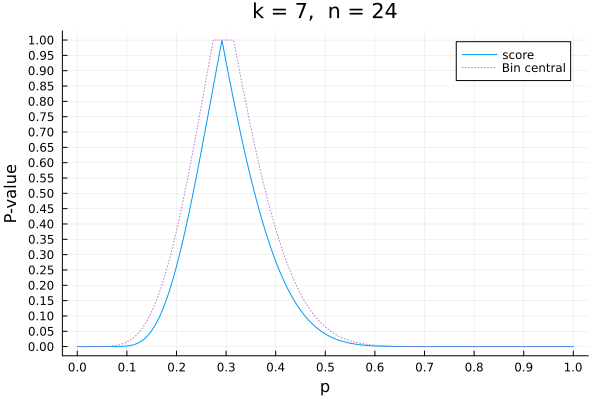

In [5]:
plot_pvalue(; k=7, n=24, f=Bool[1,0,0,1])

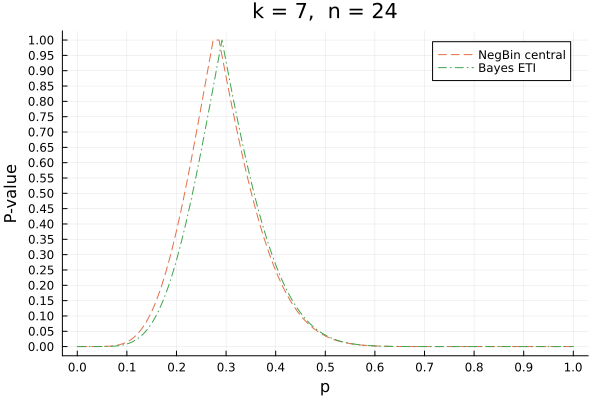

In [6]:
plot_pvalue(; k=7, n=24, f=Bool[0,1,1,0])

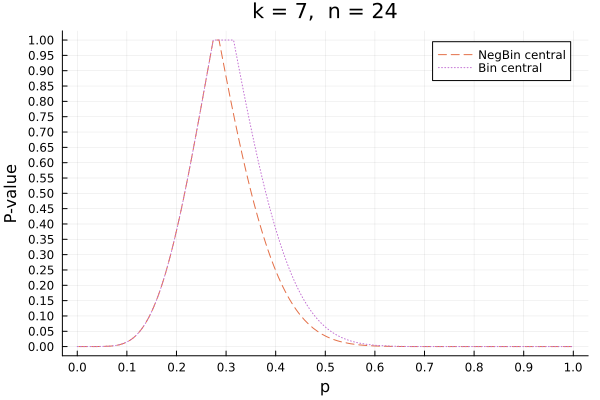

In [7]:
plot_pvalue(; k=7, n=24, f=Bool[0,1,0,1])

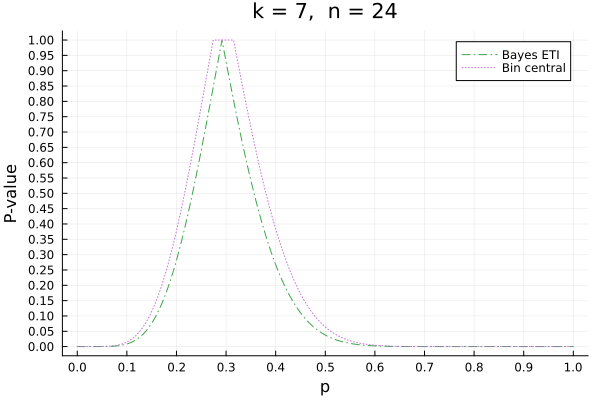

In [8]:
plot_pvalue(; k=7, n=24, f=Bool[0,0,1,1])

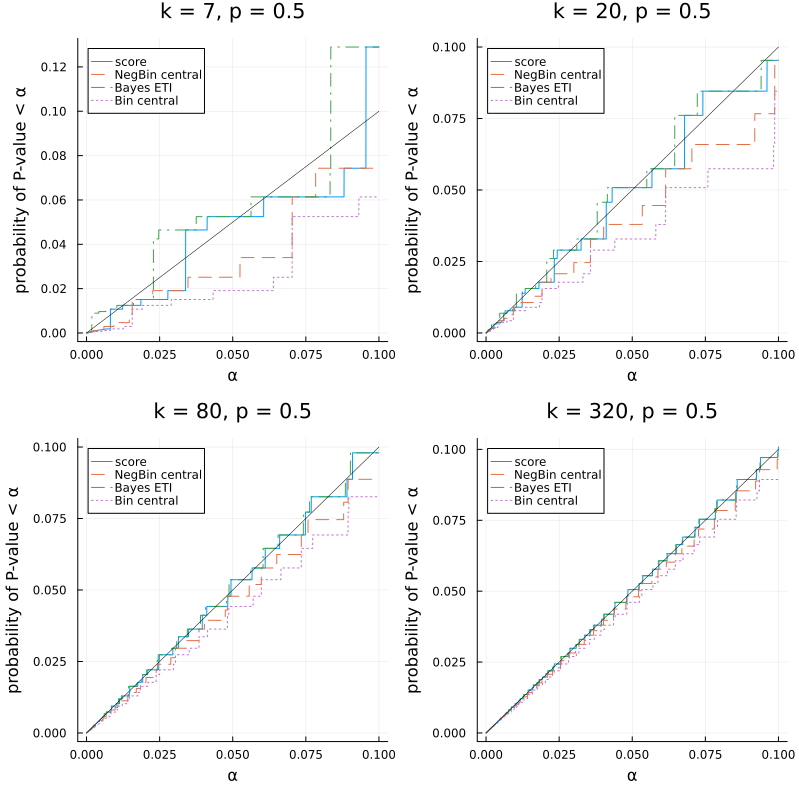

In [9]:
PP = []
for k in (7, 20, 80, 320)
    P = plot_alphaerror(; k, p=0.5, αmax=0.1)
    push!(PP, P)
end
plot(PP...; size=(800, 800), layout=(2, 2))

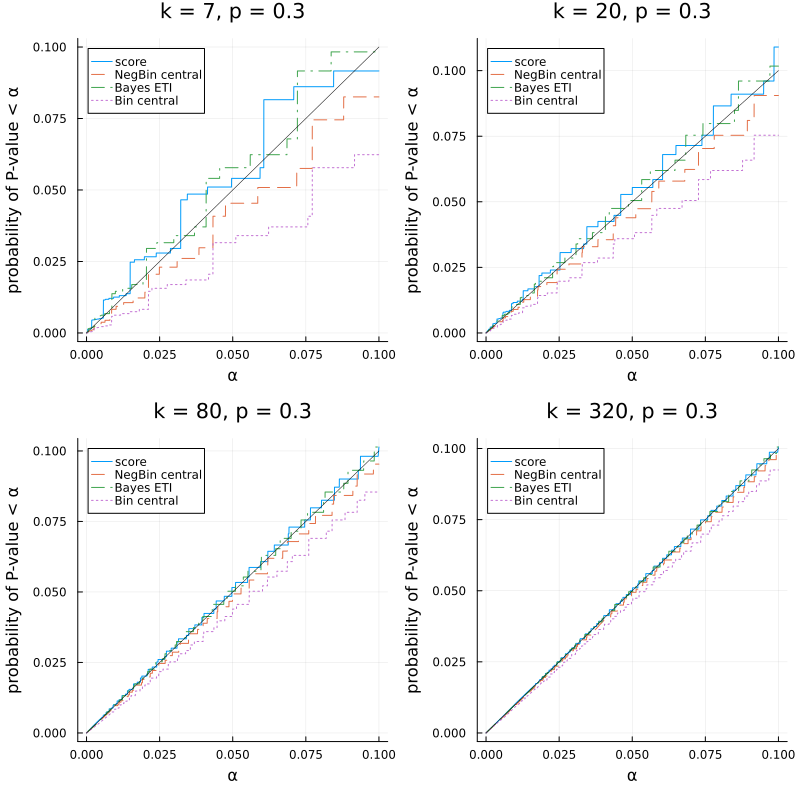

In [10]:
PP = []
for k in (7, 20, 80, 320)
    P = plot_alphaerror(; k, p=0.3, αmax=0.1)
    push!(PP, P)
end
plot(PP...; size=(800, 800), layout=(2, 2))

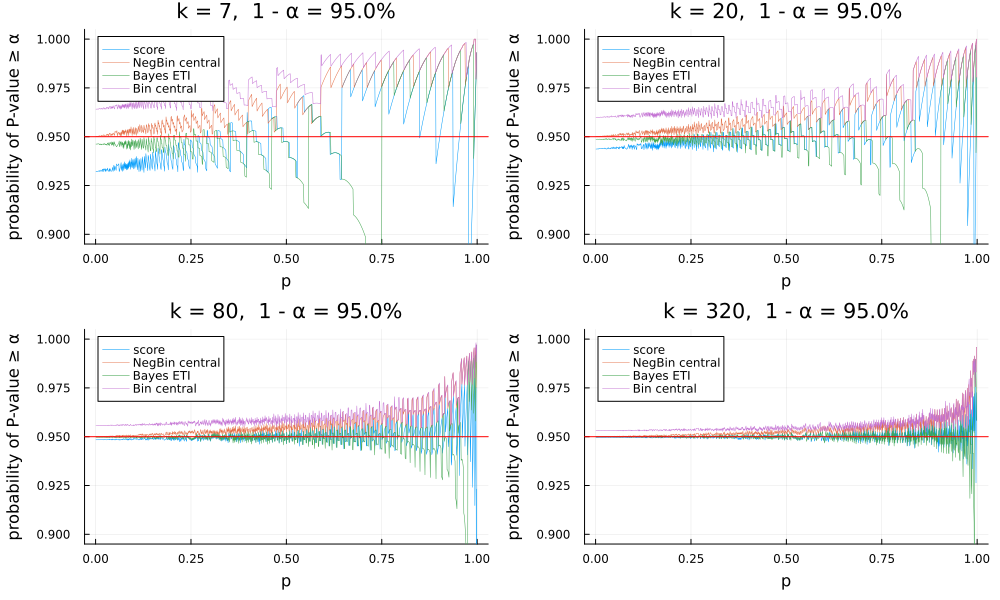

In [11]:
PP = []
for k in (7, 20, 80, 320)
    P = plot_coverageprob(; k, α=0.05, lw=0.5, f=Bool[1,1,1,1])
    push!(PP, P)
end
plot(PP...; size=(1000, 600), layout=(2, 2))
plot!(leftmargin=4Plots.mm, bottommargin=4Plots.mm)

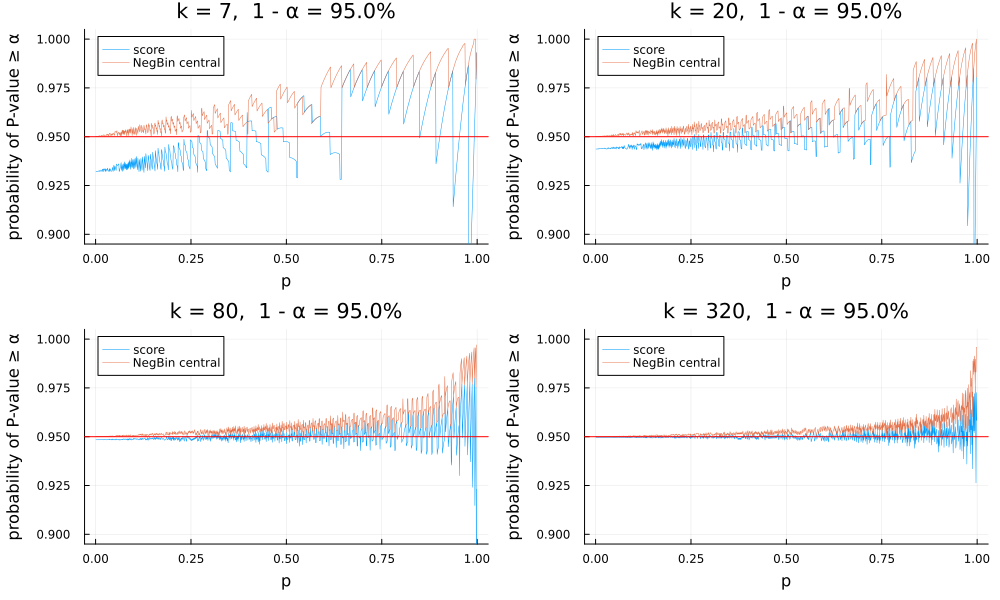

In [12]:
PP = []
for k in (7, 20, 80, 320)
    P = plot_coverageprob(; k, α=0.05, lw=0.5, f=Bool[1,1,0,0])
    push!(PP, P)
end
plot(PP...; size=(1000, 600), layout=(2, 2))
plot!(leftmargin=4Plots.mm, bottommargin=4Plots.mm)

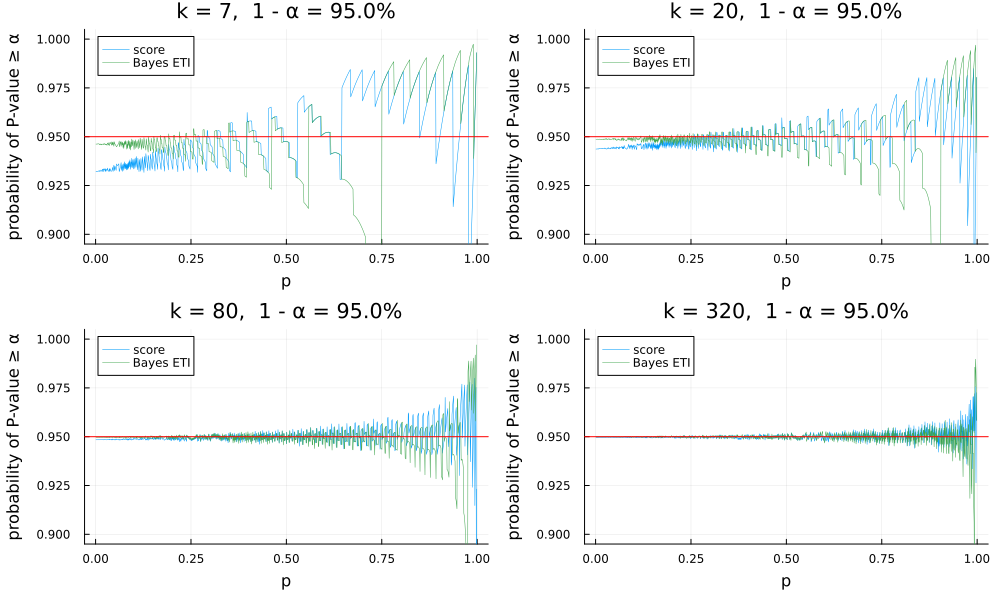

In [13]:
PP = []
for k in (7, 20, 80, 320)
    P = plot_coverageprob(; k, α=0.05, lw=0.5, f=Bool[1,0,1,0])
    push!(PP, P)
end
plot(PP...; size=(1000, 600), layout=(2, 2))
plot!(leftmargin=4Plots.mm, bottommargin=4Plots.mm)

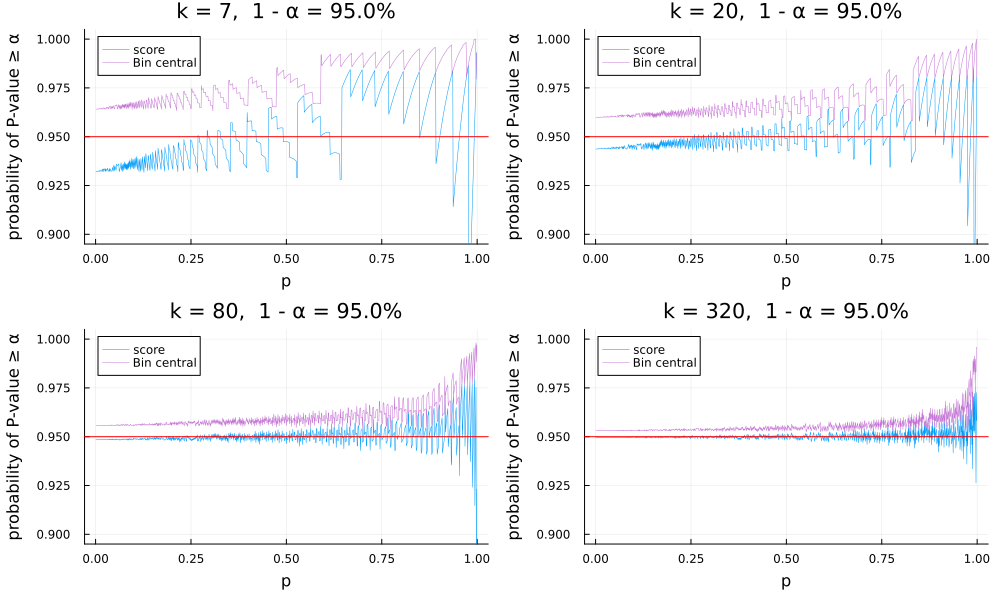

In [14]:
PP = []
for k in (7, 20, 80, 320)
    P = plot_coverageprob(; k, α=0.05, lw=0.5, f=Bool[1,0,0,1])
    push!(PP, P)
end
plot(PP...; size=(1000, 600), layout=(2, 2))
plot!(leftmargin=4Plots.mm, bottommargin=4Plots.mm)

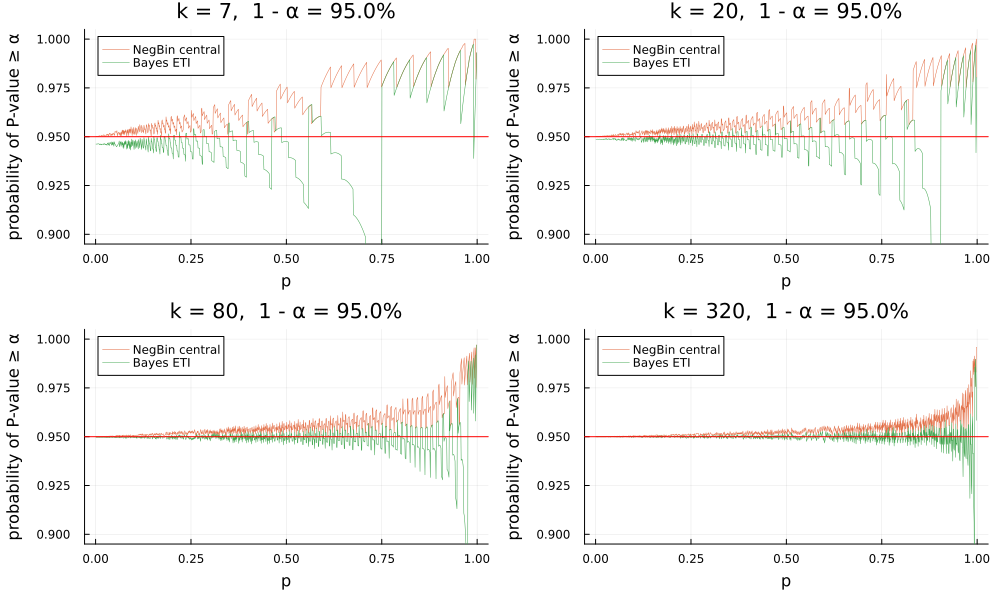

In [15]:
PP = []
for k in (7, 20, 80, 320)
    P = plot_coverageprob(; k, α=0.05, lw=0.5, f=Bool[0,1,1,0])
    push!(PP, P)
end
plot(PP...; size=(1000, 600), layout=(2, 2))
plot!(leftmargin=4Plots.mm, bottommargin=4Plots.mm)

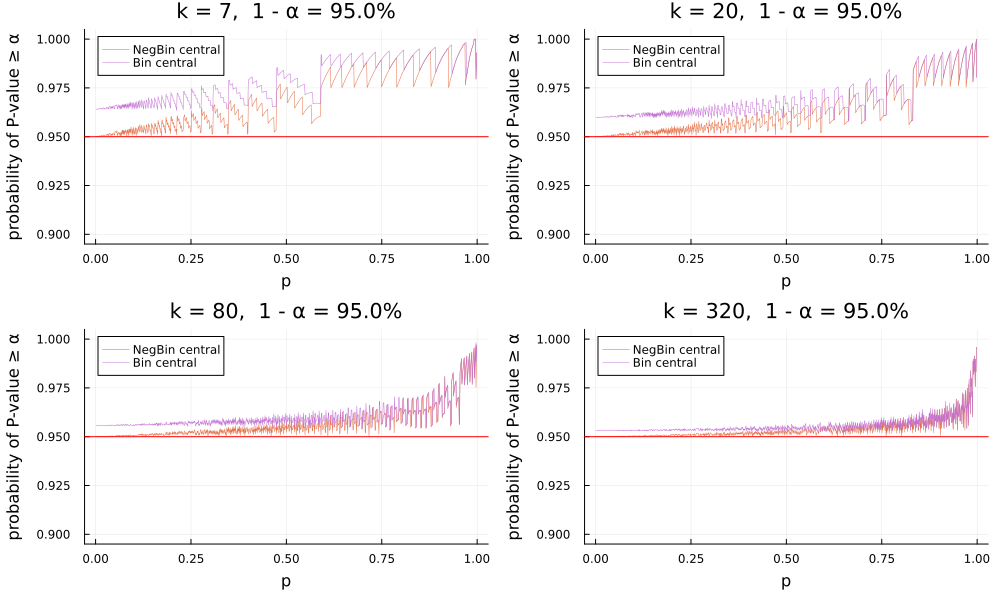

In [16]:
PP = []
for k in (7, 20, 80, 320)
    P = plot_coverageprob(; k, α=0.05, lw=0.5, f=Bool[0,1,0,1])
    push!(PP, P)
end
plot(PP...; size=(1000, 600), layout=(2, 2))
plot!(leftmargin=4Plots.mm, bottommargin=4Plots.mm)

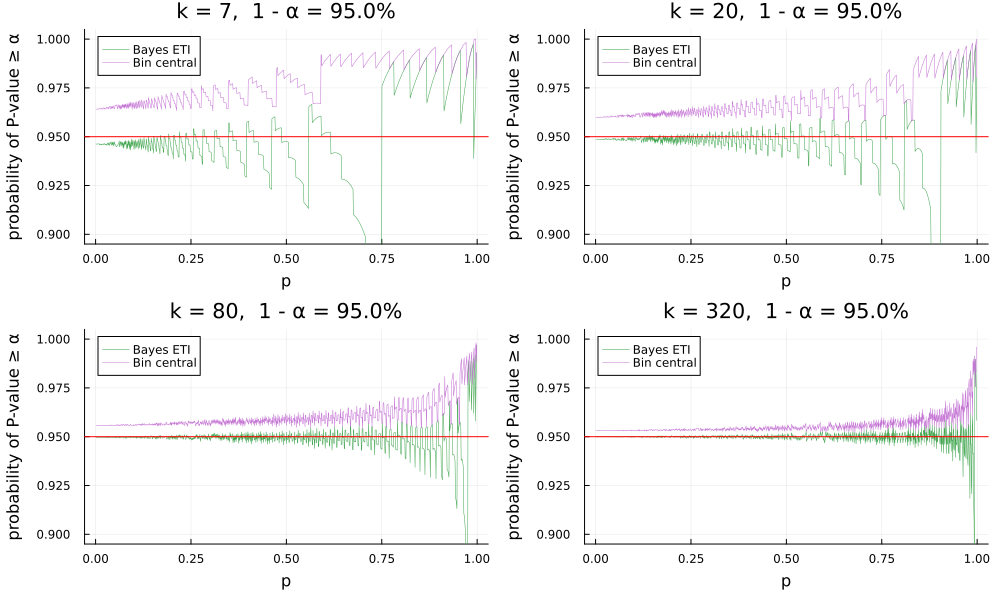

In [17]:
PP = []
for k in (7, 20, 80, 320)
    P = plot_coverageprob(; k, α=0.05, lw=0.5, f=Bool[0,0,1,1])
    push!(PP, P)
end
plot(PP...; size=(1000, 600), layout=(2, 2))
plot!(leftmargin=4Plots.mm, bottommargin=4Plots.mm)